# **Data Augmentation, améliorer rapidement son modèle de Deep Learning** - [voir l'article](https://inside-machinelearning.com/data-augmentation-ameliorer-rapidement-son-modele-de-deep-learning/)

Dans ce **notebook** nous allons voir comment utiliser la **Data Augmentation** et le **Dropout** pour améliorer un modèle classique de **Deep Learning** pour la **classification d'images** !

Nous allons **utiliser notre modèle** pour classifier **des images de chiens et de chats** bien qu'il soit utilisable sur n'importe quel **jeu de données**.

Le **code complet** est disponible sur **GitHub** [à cet adresse](https://github.com/tkeldenich/Computer_Vision_CNN_DataAugmentation.git).

L'**objectif** de ce notebook est de créer un modèle de **Deep Learning** capable de repérer sur une image un chien ou un chat. Le modèle aura seulement **deux types de réponse** : 'chien' ou 'chat', c'est donc une **classification binaire**.

Nous allons prendre un **petit jeu de donnés** (4000 images) intentionnellement pour que le modèle ne soit pas optimal. Cela nous permettra de voir comment **améliorer notre modèle** malgré cette contrainte.

## **Entraîner le modèle CNN**

### **Charger les données**

Tout d'abord nous allons charger sur le notebook le **fichier zip** contenant les **images de chats et de chiens** dont nous avons besoin.

Ces images sont des données à **3 dimensions**:
- **hauteur**
- **longueur**
- **couleur** (Rouge, Vert, Bleu)

Où **chaque couleur** (RVB) est représenté sur une **échelle de nuance de 0 à 255**.

Le **fichier** contenant nos images **se trouve** sur [Github](https://github.com/tkeldenich/Computer_Vision_CNN_DataAugmentation.git)

In [1]:
!git clone https://github.com/tkeldenich/Image_Recognition_CNN_DataAugmentation.git

Cloning into 'Image_Recognition_CNN_DataAugmentation'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 3
Unpacking objects: 100% (7/7), done.


On **dézip** le fichier :

In [2]:
from zipfile import ZipFile

with ZipFile('/content/Image_Recognition_CNN_DataAugmentation/images.zip', 'r') as zipObj:
   zipObj.extractall('images')

Ce fichier contient **plusieurs sous-fichiers** hiérarchisés:
- **train**, pour l'entraînement du modèle
- **validation**, pour vérifer si le modèle est overfit
- **test**, pour tester le modèle

Chacun de ces fichiers contient un **répertoire cats** (chats) et un **répertoire dogs** (chiens).

Cela permet de savoir directement à **quel label** (chat ou chien) **une image fait référence**. Ces répertoires seront utiles notamment **lors de la labellisation** faite dans la partie **Générateur & Preprocessing**.

Pour **chaque fichier**, on crée une **variable** contenant le **chemin du fichier**.

In [3]:
train_dir = 'images/train/'
validation_dir = 'images/validation/'
test_dir = 'images/test/'

train_cats_dir = 'images/train/cats'
train_dogs_dir = 'images/train/dogs'
validation_cats_dir = 'images/validation/cats'
validation_dogs_dir = 'images/validation/dogs'
test_cats_dir = 'images/test/cats'
test_dogs_dir = 'images/test/dogs'

On peut par la suite afficher **la nombre d'images de chaque fichier** pour voir si l'on en a bien 4000.

In [4]:
import os

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## **Les générateurs**

Une fois que les données sont **chargés dans notre environnement** nous allons les **insérer dans des variables**... mais pas n'importe quelles variables.. des **générateurs !**

En fait **les générateurs** sont des **fonctions dans lequel on stocke des variables**, des éléments ou encore des images.

**L'avantage des générateurs** c'est qu'ils ne calculent pas la valeur de chaque élément. En effet, **ils calculent les éléments uniquement lorsqu'on leur demande de le faire**. C'est ce qu'on appelle une **évaluation paresseuse** (**lazy evaluation**).

Cette **évaluation paresseuse** est utile lorsque l'on a un **très grand nombre de données** à calculer. Elle permet d'**utiliser immédiatement les données déjà calculées**, pendant que le reste des données est en cours de calcul.

Les générateurs permettent donc un **gain de rapidité et d'espace mémoire !**

Cette méthode est particulièrement **pratique** pour l'entraînement d'un **modèle de Deep Learning** qui fonctionne sur des **lots de donnée**(batch). Les lots sont chargés seulement **lorsque le modèle en a besoin** (par itération).

Dans notre cas, on va utiliser la fonction *ImageDataGenerator* qui permet d'**initialiser des générateurs Python** pour charger des images.

*ImageDataGenerator* permet aussi de **redimensionner les valeurs RVB**.

C'est une méthode idéal qui permet au modèle d'être plus précis. Nous allons donc **redimensionner** cette échelle de 0 à 255 en **0 à 1**.


In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

## **Preprocessing**

On a **initialisé nos générateurs**, maintenant il faut leur **indiquer où chercher nos images** !

Pour cela, on utilise la fonction *flow_from_directory*  qui permet de charger des **lots de données** depuis un chemin de fichier.

Cette fonction a de nombreux paramètres qui nous **facilite vraiment la tâche**, on peut remercier ceux qui l'ont codé !

Les **paramètres** que l'on utilise :
- **le chemin du fichier**, que l'on a déjà stocké dans des variables plus tôt

- **batch_size**, la taille du lot d'images à charger. Ici on choisit des lots de **20 images**.

- **target_size**, le générateur peut redimensionner automatiquement la hauteur et la largeur des images chargés. On choisit une dimension petite de **150x150** pour que le modèle s'entraîne plus rapidement

- **class_mode**, ce paramètre permet de choisir le type de labellisation que l'on veut. Dans notre cas, nous voulons détecter le label 'chien' ou 'chat'. Soit l'un, soit l'autre. C'est donc une classification binaire, on utilise donc **'binary'** !

Ces **quatres paramètres nous suffisent** mais il en existe bien d'autre si l'on veut **pousser davantage la configuration** de nos générateurs, [n'hésitez pas à regarder la documentation pour en apprendre plus !](https://keras.io/api/preprocessing/image/)

In [6]:
train_generator = datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    target_size=(150, 150),
                                                    class_mode='binary')

validation_generator = datagen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        target_size=(150, 150),
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


On peut **vérifier** que les lots d'images créés **correspondent** aux dimensions voulu en utilisant la fonction *shape*.

In [7]:
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


On a bien des **lots de 20 images** de **dimensions 150x150x3** et des **lots de 20 labels**, 'chien' ou 'chat', **un pour chaque image**. 

## **Construire le modèle**

Nos **données sont prétraités**, nous pouvons maintenant **construire notre modèle !**

On travaille **avec des images**, nous allons donc utilisé un modèle à **couches de convolution** comme expliqué dans [cet article](https://inside-machinelearning.com/cnn-couche-de-convolution/).

Le **nombre de couches** dépend de la **complexité du problème** et de la **taille des images**. Ici, quatre couches *MaxPooling* sont suffisantes.

Reste à savoir quelle **fonction d'activation** utiliser. Il suffit de se référer à [cet article](https://inside-machinelearning.com/fonction-dactivation-comment-ca-marche-une-explication-simple/#Quelle_fonction_pour_quel_cas) pour **savoir rapidement** quelle fonction est **pertinente**.

Dans notre cas, on utilise la fonction *sigmoid* dans la **dernière couche** de notre modèle pour faire de la **classification binaire**.

In [8]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Ensuite, nous pouvons **compiler notre modèle**, configuer son apprentissage.

On choisit comme **loss function** 'binary_crossentropy', comme **optimisateur** RMSprop et la métrique 'acc' pour accuracy (précision).

Nous n'avons pas encore écrit d'**articles** aux sujets de ces fonctions mais **ça ne saurait tarder !** :)

In [9]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## **Entraîner le modèle**

On **entraîne le modèle** avec la fonction *fit_generator()*, c'est le même principe que la fonction *fit()* mais adapté aux **générateurs**.

On choisit **ces paramètres** pour l'entraînement :
- le **chemin du fichier** contenant les données d'entraînement
- le **nombre d'epoch**, le nombre de fois que le modèle repasse sur l'ensemble de données
- **steps_per_epoch**, est en fait similaire a batch_size, ici 100 steps_per_epoch correspond à un batch_size de 20 (nombre de données d'entraînement divisé par nombre de steps_per_epoch)
- le chemin du fichier contenant les **données de validation** (pour évaluer l'overfitting du modèle)
- **validation_steps**, c'est le nombre de steps_per_epoch après lequel le modèle se test sur les données de validation

On peut résumer ces paramètres ainsi :  le modèle **s'entraîne 30 fois sur l'ensemble de données**. Chaque fois qu'il s'entraîne, les **données sont divisés en 100 lots** (batch) sur lesquels il se focalise un à un. À chaque fois qu'il a visité **50 lots**, il **teste son apprentissage** sur l'ensemble des données de validation.

*Pour cet entraînement il est conseillé d'avoir un GPU, sinon d'utiliser le GPU intégré à Google Colab (gratuit).*




In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 16s 89ms/step - loss: 0.6960 - acc: 0.5290 - val_loss: 0.6782 - val_acc: 0.5560
Epoch 2/30
100/100 [==============================] - 9s 87ms/step - loss: 0.6634 - acc: 0.5933 - val_loss: 0.6440 - val_acc: 0.6200
Epoch 3/30
100/100 [==============================] - 9s 87ms/step - loss: 0.6101 - acc: 0.6596 - val_loss: 0.6179 - val_acc: 0.6560
Epoch 4/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5628 - acc: 0.7232 - val_loss: 0.6025 - val_acc: 0.6820
Epoch 5/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5363 - acc: 0.7270 - val_loss: 0.6104 - val_acc: 0.6790
Epoch 6/30
100/100 [==============================] - 9s 86ms/step - loss: 0.5093 - acc: 0.7466 - val_loss: 0.6383 - val_acc: 0.6550
Epoch 7/30
100/100 [==============================] - 9s 85ms/step - loss: 0.4729 - acc: 0.7650 - val_loss: 0.6070 - val_acc: 0.6810
Epoch 8/30
100/100 [==============================] - 9s 86ms/step -

On ne l'a pas vu précédemment, mais il est toujours conseillé de **sauvegarder notre modèle après l'apprentissage**, cela permet d'éviter de recommencer l'entraînement à chaque nouvelle session.

Vous pouvez le **sauvegarder facilement** avec la fonction *save()* et lors d'une **nouvelle session** vous pourrez le **charger** avec la fonction *load_model()*.

In [11]:
model.save('model_trained.h5')

#model = model.load_model('model_trained.h5')

## **Évaluer le modèle**

On **évalue notre modèle** en comparant les **métriques**, les courbes de **loss** et les courbes de **précision**.

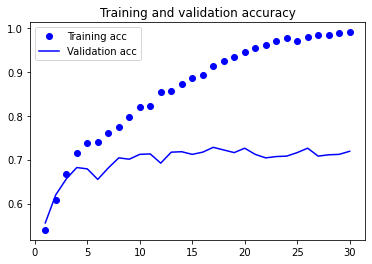

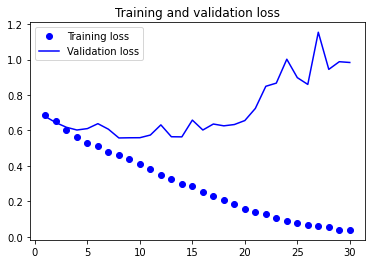

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Sur les **données d'entraînement**, le modèle est **de plus en plus performant** mais sur les **données de validation** il stagne, voir devient **de moins en moins bon**.

Le modèle **se spécialise sur les données d'entraînement** mais n'est plus capable d'**interpréter** les données de validations (et les données réelles en général), il est en **overfitting**.

Essayons notre modèle sur les **données de test** :

In [13]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.evaluate(test_generator)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 3s 52ms/step - loss: 0.9935 - acc: 0.7390


[0.9935357570648193, 0.7390000224113464]

**La précision est de 0.74**, les perfomances sont bonnes mais pas exceptionnelles.

**Pas de soucis néanmoins, on peut améliorer notre modèle !**

# **Contourner l'overfitting**

## **Data Augmentation**

### **Qu'est-ce que c'est ?**

L'**overfitting** est dû au fait que l'on dispose de trop **peu de données**.

Le modèle a trop **peu de cas d'usage différent** ce qui rend difficile son entraînement. Par conséquent , il ne peut pas **développer des règles** de décisions pouvant être **généralisé à de nouvelles données**.

Il nous faut **plus de données**... et donc dans notre cas, **plus de photos**. Ce n'est pas une tâche facile a faire.

**Heureusement**, il existe une **technique** pour augmenter notre nombre de données. On peut créer des **images artificielles** grâce à la **Data Augmentation** (littéralement : l'augmentation des données).

L'idée derrière la **Data Augmentation** est de reproduire les données préexistantes en leur appliquant une **transformation aléatoire**. Par exemple, appliquer un **effet mirroir** sur une image.

Lors de l'entraînement, notre modèle apprendra sur **beaucoup plus de données** tout en ne rencontrant **jamais deux fois la même image**.

Le modèle est donc **exposé à davantage de données**. Cela lui permet de **mieux généraliser**.

**Vérifions cela maintenant !** ;)

### **Comment l'utiliser ?**

On peut faire de la **Data Augmentation** en utilisant la fonction *ImageDataGenerator* déjà utilisé plus haut et en **modifiant certains paramètres** :

- **rotation_range** pour faire pivoter une image de façon aléatoire sur une plage entre 0 et la valeur choisis (maximum 180 degré)
- **width_shift** et **height_shift** sont des plages (en fraction de la largeur ou de la hauteur totale) à l'intérieur desquelles on peut redimensionner aléatoirement des images verticalement ou horizontalement.
- **shear_range** est une plage permettant de rogner(découper) de manière aléatoire l'image
- **zoom_range** permet de zoomer de manière aléatoire à l'intérieur des images
- **horizontal_flip** retourne horizontalement des images de manière aléatoire (certaines seront retourner d'autres non)
- **fill_mode** est la stratégie utilisée pour remplir les pixels nouvellement créés, qui peuvent apparaître après un pivotage, un rognage, etc

On utilise **ces quelques paramètres** mais encore une fois, il en existe d'autres sur [la documentation Keras !](https://keras.io/api/preprocessing/image/)

In [14]:
augmented_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Ensuite, on peut **afficher ces nouvelles images** pour voir concrétement ce qu'a produit notre **Data Augmentation**.

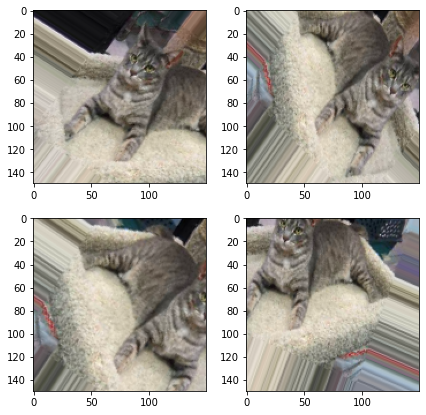

In [15]:
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for
     fname in os.listdir(train_cats_dir)]

img_path = fnames[4]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(7,7))

for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

**Pour visualiser les images augmentées**, on a appliqué le **paramètre** *fill_mode*.

Pour l'**entraînement du modèle** il n'est pas nécessaire de l'utiliser. On initialise donc un **générateur** sans ce paramètre.

In [16]:
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

La **Data Augmentation** concerne seulement les **données d'entraînement**... pour les autres données on initialise un **générateur simple** !

In [17]:
datagen = ImageDataGenerator(rescale=1./255)

Comme pour le premier entraînement, on indique **le chemin des fichiers contenant nos images** aux deux générateurs et on **configure le preprocessing** a effectuer.

In [18]:
train_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Une étape de **vérification des dimensions**, toujours utile:

In [19]:
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


## **Dropout**

Le **modèle** ne verra jamais deux fois la même donnée mais certaines images qu'il voit sont **fortement similaires**. Les données sont corrélées car elles proviennent d'un petit nombre d'images de base. Avec la **Data Augmentation** on ne peut pas produire de **nouvelles informations**, on peut seulement remanier, **remixer des informations existantes**.

Cela peut ne pas être suffisant pour se débarrasser complètement de l'**overfitting**. On va donc utilisez une deuxième technique: le **Dropout**.

Dans un modèle de **Deep Learning**, chaque couche  du réseau apprend lors de la **phase d'entraînement** du modèle.

Lors de cet entraînement, **des poids sont associés aux neurones** de chaque couche.

Ces **poids représentent l'apprentissage** du modèle. Plus ils sont élevés, **plus le neurone a d'influence** sur la donnée.

L'idée du **Dropout** est de **supprimer aléatoirement certains de ces neurones** et donc supprimer les poids associés. Cela peut paraître paradoxale mais cette technique permet d'**améliorer l'apprentissage du modèle**.

En écartant certains neurones **lors de l'apprentissage**, les autres **neurones** sont contraint de **se surpasser** pour que la couche donne de bon résultats.

En fait, on ajoute du **bruit** pendant l'apprentissage du modèle ce qui a pour effet de **contraindre les neurones restant à être plus robuste** et donc plus performant. **Le réseaux de neurones s'adapte** à la situation !

Le *Dropout* est une **couche** a part entière. L'idée est de l'utiliser après avoir configuré les **couches convolutionnelles** (MaxPooling2D et Flatten).

In [20]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['acc'])

## **Entraîner le nouveau modèle**

On **entraîne notre modèle** avec la fonction *fit_generator()* mais cette fois avec 100 epochs car on sait que le modèle ne va pas overfitter rapidement grâce à la **Data Augmentation** et au **Dropout**.

In [21]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 18s 175ms/step - loss: 0.6948 - acc: 0.5098 - val_loss: 0.6860 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 17s 170ms/step - loss: 0.6874 - acc: 0.5483 - val_loss: 0.6783 - val_acc: 0.5410
Epoch 3/100
100/100 [==============================] - 17s 170ms/step - loss: 0.6716 - acc: 0.5713 - val_loss: 0.6944 - val_acc: 0.5400
Epoch 4/100
100/100 [==============================] - 17s 169ms/step - loss: 0.6542 - acc: 0.6146 - val_loss: 0.6315 - val_acc: 0.6170
Epoch 5/100
100/100 [==============================] - 17s 170ms/step - loss: 0.6404 - acc: 0.6247 - val_loss: 0.6199 - val_acc: 0.6410
Epoch 6/100
100/100 [==============================] - 17s 170ms/step - loss: 0.6126 - acc: 0.6618 - val_loss: 0.6106 - val_acc: 0.6590
Epoch 7/100
100/100 [==============================] - 17s 170ms/step - loss: 0.6179 - acc: 0.6474 - val_loss: 0.6230 - val_acc: 0.6300
Epoch 8/100
100/100 [===========================

Ensuite, on **sauvegarde** notre **nouveau modèle**.

In [22]:
model.save('model_trained_enhanced.h5')

#model = model.load_model('model_trained_enhanced.h5')

Et on trace les **courbes de précision et de loss** pour vérifier si le modèle **overfit** !

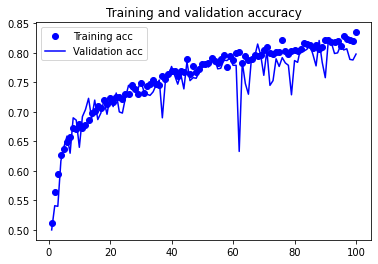

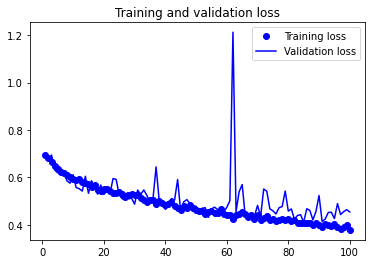

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Le modèle overfit beaucoup moins et beaucoups moins vite, nos deux techniques ont donc bien marché ! :)

On vérifie cela sur nos **données de test** :

In [24]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.evaluate(test_generator)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 3s 51ms/step - loss: 0.4608 - acc: 0.7950


[0.46075958013534546, 0.7950000166893005]

Une **perte de 0.46** et une **précision 0.79**, on a réussi a **améliorer notre modèle**.

Il est **toujours possible de faire mieux** alors n'hésitez pas à reprendre le code et le **modifier par vous-même** !